 # Notebook description
 In this notebook a report is made which includes:
 1. Top 10 lowest delays ratio
 2. Top 10 highest delays ratio 
 3. 2019 vs 2020 comparison to see if covid had any influence. 
     - month to month comparison
     - day to day comparison
 4. Daily delays ratio



 Libraries import and loading enviroment variables

In [1]:
from sqlalchemy import create_engine
from sqlalchemy.engine import URL
from dash import Dash, dcc, html, callback, Input, Output, dash_table
import plotly.express as px
import pandas as pd
from dotenv import load_dotenv
from os import environ

In [2]:
dotenv_path = '../.env'
load_dotenv(dotenv_path)

True

In [3]:
username = environ.get('db_username')
password = environ.get('db_password')

host = environ.get('db_host')
database = environ.get('db_database')
port = environ.get('db_port')

Creating connection variables

In [4]:
url = URL.create(
    "postgresql",
    username=username,
    password=password,
    host=host,
    database=database,
)
engine = create_engine(url)

Creating function that downloads data from database into dataframe

In [5]:
def read_sql_table(tablename):
    return pd.read_sql(f'select * from {tablename}', engine)

 # Create`TOP 10 routes` table


Loading data to `top_routes_df` from `reporting.top_reliability_roads`

In [6]:
top_routes_df = read_sql_table('reporting.top_reliability_roads')
top_routes_df.head(1)

,origin_airport_id,origin_airport_name,dest_airport_id,dest_airport_name,year,cnt,reliability,nb
0,12173,"LOS ANGELES INTERNATIONAL AIRPORT, CA US",13830,"HONOLULU INTERNATIONAL AIRPORT, HI US",2019,10735,0.24,1


Updating format of reliability `reliability`

In [7]:
top_routes_df['reliability'] = top_routes_df['reliability'].transform(lambda x: '{:,.0%}'.format(x))
top_routes_df.head(1)

,origin_airport_id,origin_airport_name,dest_airport_id,dest_airport_name,year,cnt,reliability,nb
0,12173,"LOS ANGELES INTERNATIONAL AIRPORT, CA US",13830,"HONOLULU INTERNATIONAL AIRPORT, HI US",2019,10735,24%,1


Renaming columns

In [8]:
top_routes_df = top_routes_df.loc[:,['origin_airport_id', 'dest_airport_id', 'year', 'reliability', 'nb']]
top_routes_df.columns = ['Origin', 'Destination', 'Year', 'Reliability', 'Rank']
top_routes_df = top_routes_df.sort_values('Reliability').head(10)
top_routes_df.head(100)

,Origin,Destination,Year,Reliability,Rank
0,12173,13830,2019,24%,1
1,12478,12892,2019,25%,2
2,13830,12173,2019,26%,3
3,10721,12953,2019,31%,4
4,12953,10721,2019,31%,4
5,14771,12892,2019,31%,4
6,12953,13930,2019,32%,5
7,12892,14771,2019,33%,6
8,12889,12892,2019,33%,6
9,12892,12478,2019,35%,7


 # Comparing  2019 vs. 2020
Creating a plot and component to put in the dashboard

Loading data from `reporting.year_to_year_comparision` view

In [9]:
yoy_comparision_df = read_sql_table('reporting.year_to_year_comparision')
yoy_comparision_df.head(1)

,year,month,flights_amount,reliability
0,2019,1,89455,0.34


Transforming dataframe

In [10]:
yoy_comparision_to_plot_df = yoy_comparision_df.loc[:,['year', 'month', 'reliability']]
yoy_comparision_to_plot_df['year'] = pd.to_datetime(yoy_comparision_to_plot_df['year'], format = '%Y').dt.strftime('%Y')
yoy_comparision_to_plot_df['reliability'] = round(yoy_comparision_to_plot_df['reliability'] * 100, 2)
yoy_comparision_to_plot_df.head(1)

,year,month,reliability
0,2019,1,34.0


Creating a barplot of reliability depending on year and month

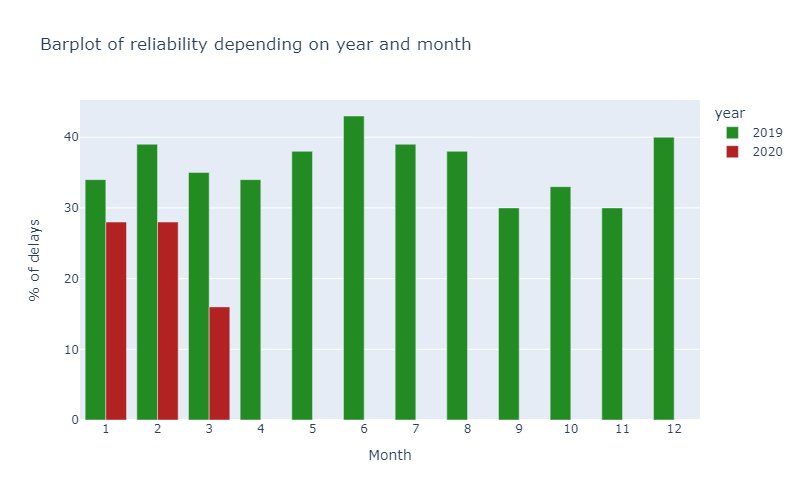

In [11]:
yoy_comparision_fig = px.bar(yoy_comparision_to_plot_df,
                      x='month',
                      y = 'reliability',
                      title='Barplot of reliability depending on year and month',
                      color = 'year',
                      color_discrete_map = {
                          '2019': 'forestgreen',
                          '2020': 'firebrick'
                      },
                      width = 800, 
                      height = 500,
                      hover_data = ['year', 'month', 'reliability'],
                      barmode = 'group'
                      )
yoy_comparision_fig.update_layout(xaxis_title="Month", yaxis_title="% of delays")
yoy_comparision_fig.update_xaxes(dtick = 'month')

yoy_comparision_fig.show('png')

 # Comparing weekday to weekday in 2019 and 2020


Loading `reporting.day_to_day_comparision` view to dataframe

In [12]:
day_to_day_comparision_df = read_sql_table('reporting.day_to_day_comparision')
day_to_day_comparision_df.head(1)

,year,day_of_week,flights_amount
0,2019,1,167761


Converting 'year' column to datetime format

In [13]:
day_to_day_comparision_df['year'] = pd.to_datetime(day_to_day_comparision_df['year'], format = '%Y').dt.strftime('%Y')
day_to_day_comparision_df.head(1)

,year,day_of_week,flights_amount
0,2019,1,167761


Creating a barplot of amount of flights in each weekday depending on year

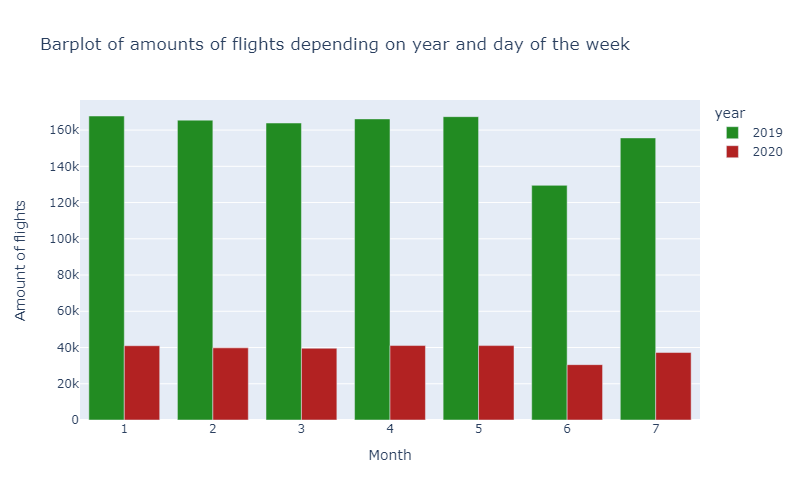

In [14]:
day_to_day_comparision_fig = px.bar(day_to_day_comparision_df,
                      x='day_of_week',
                      y = 'flights_amount',
                      title='Barplot of amounts of flights depending on year and day of the week',
                      color = 'year',
                      color_discrete_map = {
                          '2019': 'forestgreen',
                          '2020': 'firebrick'
                      },
                      width = 800, 
                      height = 500,
                      hover_data = ['year', 'day_of_week', 'flights_amount'],
                      barmode = 'group'
                      )
day_to_day_comparision_fig.update_layout(xaxis_title="Month", yaxis_title="Amount of flights")
day_to_day_comparision_fig.update_xaxes(dtick = 'day_of_week')

day_to_day_comparision_fig.show('png')

 # Creating time series
A time series show day by day delays ratio

Loading `reporting.day_by_day_reliability` view

In [15]:
day_by_day_reliability_df = read_sql_table('reporting.day_by_day_reliability')
day_by_day_reliability_df['year'] = pd.to_datetime(day_by_day_reliability_df['date']).dt.strftime('%Y')
day_by_day_reliability_df['reliability'] = round(day_by_day_reliability_df['reliability'] * 100, 2)
day_by_day_reliability_df.head(1)

,date,reliability,year
0,2019-01-01,40.0,2019


Creating barplot of day by day delays ratio

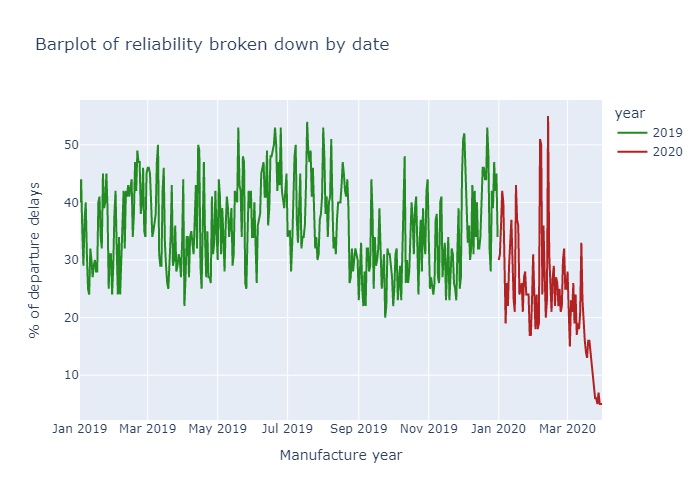

In [16]:
day_by_day_reliability_fig = px.line(day_by_day_reliability_df,
                      x='date',
                      y = 'reliability',
                      title='Barplot of reliability broken down by date',
                      color = 'year',
                      color_discrete_map = {
                          '2019': 'forestgreen',
                          '2020': 'firebrick'
                      })
day_by_day_reliability_fig.update_layout(xaxis_title="Manufacture year", yaxis_title="% of departure delays")
day_by_day_reliability_fig.update_yaxes(dtick = 10)

day_by_day_reliability_fig.show('png')

 # Creating layouts for each page

 ## Creating top 10 routes layout
Creating dash.Datatable object to put in the dashboard

In [17]:
top_routes_df.head(1)

,Origin,Destination,Year,Reliability,Rank
0,12173,13830,2019,24%,1


In [18]:
top_routes_table = dash_table.DataTable(
    id='top_10_routes_table',
    columns=[{'name': col, 'id': col} for col in top_routes_df.columns],
    data=top_routes_df.to_dict('records'),
)
top_routes_table

DataTable(data=[{'Origin': 12173, 'Destination': 13830, 'Year': 2019, 'Reliability': '24%', 'Rank': 1}, {'Origin': 12478, 'Destination': 12892, 'Year': 2019, 'Reliability': '25%', 'Rank': 2}, {'Origin': 13830, 'Destination': 12173, 'Year': 2019, 'Reliability': '26%', 'Rank': 3}, {'Origin': 10721, 'Destination': 12953, 'Year': 2019, 'Reliability': '31%', 'Rank': 4}, {'Origin': 12953, 'Destination': 10721, 'Year': 2019, 'Reliability': '31%', 'Rank': 4}, {'Origin': 14771, 'Destination': 12892, 'Year': 2019, 'Reliability': '31%', 'Rank': 4}, {'Origin': 12953, 'Destination': 13930, 'Year': 2019, 'Reliability': '32%', 'Rank': 5}, {'Origin': 12892, 'Destination': 14771, 'Year': 2019, 'Reliability': '33%', 'Rank': 6}, {'Origin': 12889, 'Destination': 12892, 'Year': 2019, 'Reliability': '33%', 'Rank': 6}, {'Origin': 12892, 'Destination': 12478, 'Year': 2019, 'Reliability': '35%', 'Rank': 7}], columns=[{'name': 'Origin', 'id': 'Origin'}, {'name': 'Destination', 'id': 'Destination'}, {'name': 'Ye

Creating table header

In [19]:
top_routes_page_title = html.H3(
    'TOP 10 reliability routes in 2019 and 2020',
    style = {'fontFamily': 'verdana', 'color': '#4444'}
)

Creating layout for `TOP 10 routes` view

In [20]:
top_routes_layout = html.Div([
    top_routes_page_title,
    top_routes_table
])

### Creating layout for year to year comparission

Creating graph component of year to year comparison

In [21]:
yoy_comparision_component = dcc.Graph(id = 'yoy_graph', figure = yoy_comparision_fig)

Creating graph component of day to day comparison

In [22]:
day_to_day_comparision_component = dcc.Graph(id = 'dtd_graph', figure = day_to_day_comparision_fig)

Creating layout for comparision view

In [23]:
comparision_layout = html.Div([
    html.H3(
        'Comparision',
        style = {'fontFamily': 'verdana', 'color': '#4444'} 
    ),
    yoy_comparision_component,
    day_to_day_comparision_component
])

Creating a layout for 'day by day' view

In [24]:
day_by_day_reliability_component = dcc.Graph(id = 'dbd_graph', figure = day_by_day_reliability_fig)
day_by_day_layout = html.Div([
    html.H3(
        'Day by day reporting',
        style = {'fontFamily': 'verdana', 'color': '#4444'} 
    ),
    dcc.Graph(id = 'dbd_graph', figure = day_by_day_reliability_fig)
])

 # Configurating the application
Configurating the report application so it supports couple of pages

These are the three sites that are configured:
 - `TOP report` - default,
 - `Comparision`,
 - `Day by day reporting`


Creating app layout

In [25]:
app = Dash(__name__)
app.layout = html.Div([
    html.Button('TOP report', id = 'tr', n_clicks = 0),
    html.Button('Comparision', id = 'c', n_clicks = 0),
    html.Button('Day by day reporting', id = 'dbd', n_clicks = 0),
    html.Div(id='page-content')
])

app.layout = html.Div([
  dcc.Location(id='url', 
  refresh=False),
  dcc.Link(html.Button("Top Report"), href="/", refresh=True),
  dcc.Link(html.Button("Comparision"), href="/comparision_reporting", refresh=True),
  dcc.Link(html.Button("Day by day reporting"), href="/day_by_day_reporting", refresh=True),
  
  html.Div(id='page-content')
])

Creating a procedure to move between pages

In [26]:
@callback(
  Output('page-content', 'children'),
  Input('url', 'pathname')
)
def display_page_content(pathname):
 
  if pathname == "/comparision_reporting":
    return comparision_layout
  elif pathname == '/day_by_day_reporting':
    return day_by_day_layout
  elif '/':
    return top_routes_layout

Running the app

In [27]:
if __name__ == '__main__':
    app.run_server()